In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

data_path = './Dataset/'
data = pd.read_csv(data_path + 'hour.csv')

to_drop = ['instant', 'dteday']

data = data.drop(to_drop, axis=1)

# EDA

In [297]:
data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [298]:
data.dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [299]:
data.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [300]:
data[data['holiday']==1].head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
372,1,0,1,0,1,1,0,2,0.20,0.1970,0.47,0.2239,1,16,17
373,1,0,1,1,1,1,0,2,0.20,0.1970,0.44,0.1940,1,15,16
374,1,0,1,2,1,1,0,2,0.18,0.1667,0.43,0.2537,0,8,8
375,1,0,1,3,1,1,0,2,0.18,0.1818,0.43,0.1940,0,2,2
376,1,0,1,4,1,1,0,2,0.18,0.1970,0.43,0.1343,1,2,3


In [301]:
data.shape

(17379, 15)

## Visualizations

<Axes: xlabel='hr', ylabel='count'>

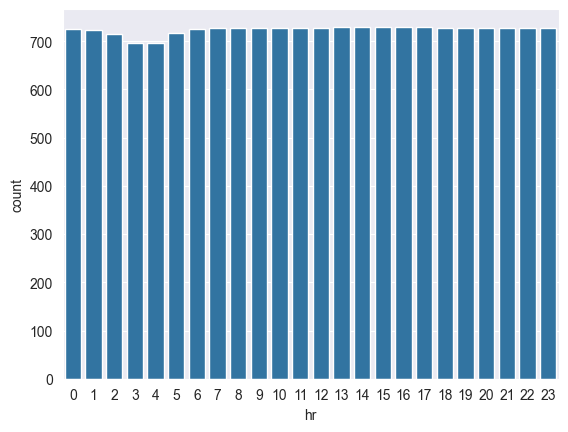

In [302]:
sns.countplot(x='hr', data=data)

<Axes: xlabel='workingday', ylabel='count'>

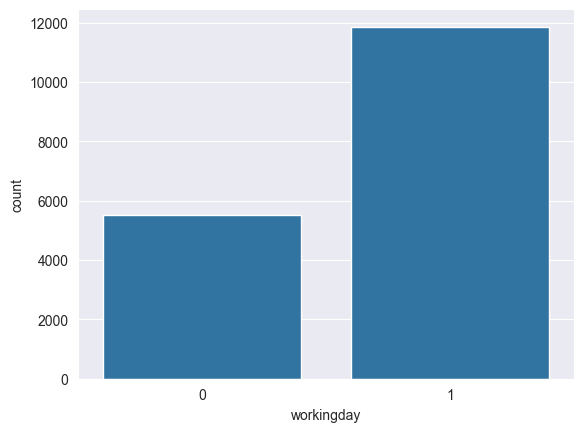

In [303]:
sns.countplot(x='workingday', data=data)

<Axes: xlabel='weekday', ylabel='count'>

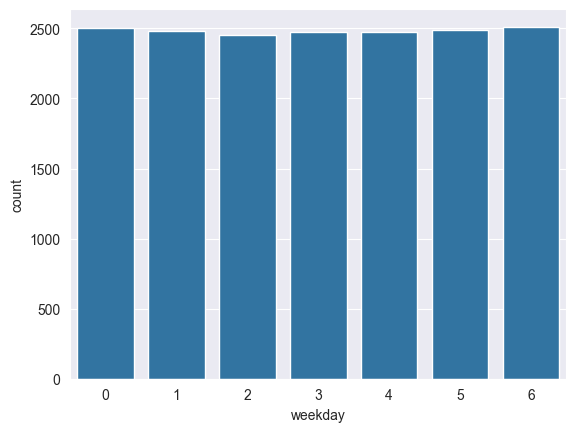

In [304]:
sns.countplot(x='weekday', data=data)

<Axes: xlabel='holiday', ylabel='count'>

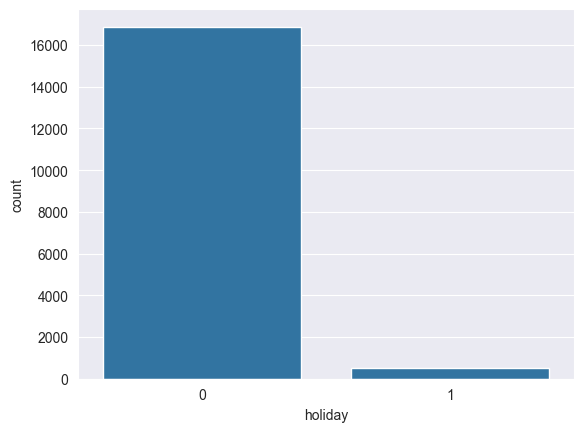

In [305]:
sns.countplot(x='holiday', data=data)

<Axes: xlabel='season', ylabel='count'>

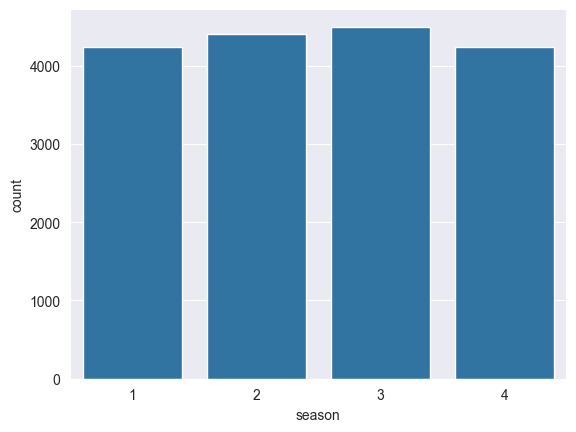

In [306]:
sns.countplot(x='season', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

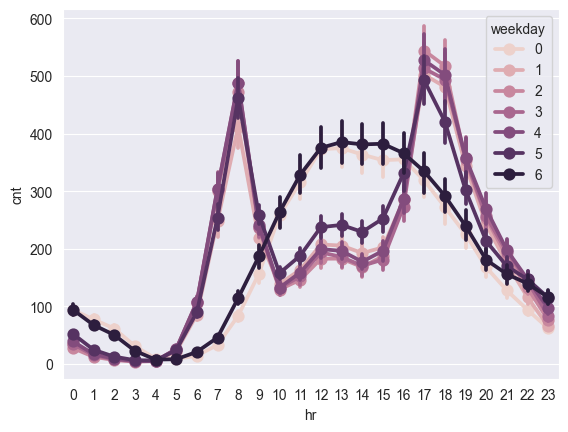

In [307]:
sns.pointplot(x='hr', y='cnt', hue='weekday', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

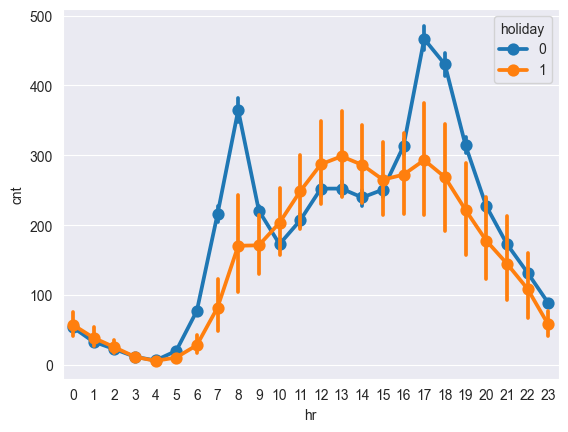

In [308]:
sns.pointplot(x='hr', y='cnt', hue='holiday', data=data)

<Axes: xlabel='hr', ylabel='cnt'>

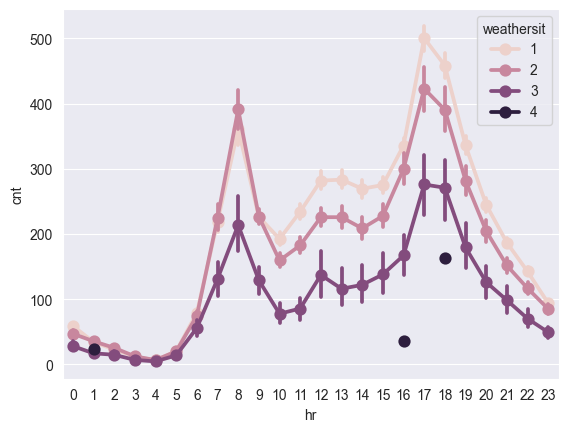

In [309]:
sns.pointplot(x='hr', y='cnt', hue='weathersit', data=data)

<Axes: xlabel='mnth', ylabel='cnt'>

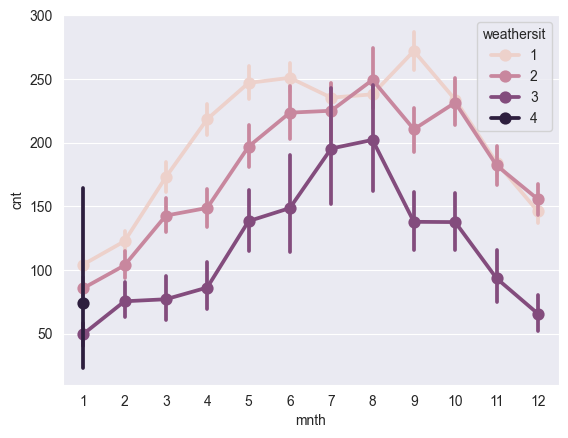

In [310]:
sns.pointplot(y='cnt', x='mnth', hue='weathersit', data=data)

## Correlation matrix

<Axes: >

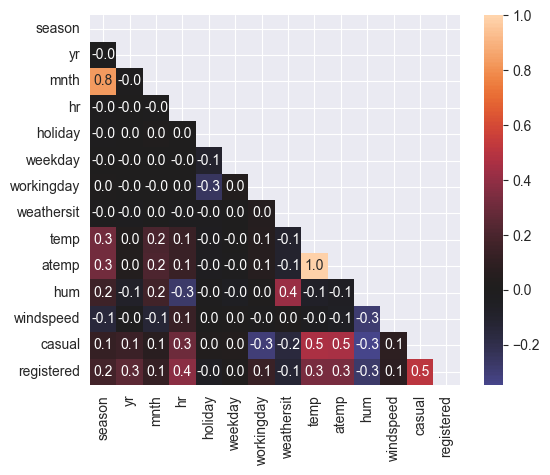

In [311]:
corr = data.loc[:,data.columns!='cnt'].corr(method="pearson")
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr,
    mask = mask,
    vmax=1,
    center=0,
    annot=True,
    fmt='.1f',
    square=True,
)

From correlation matrix it can be seen that there are dependent variables, which should be removed, like
temp and atemp


In [312]:
# data.drop('atemp')
# data.drop('')

In [313]:
print(np.corrcoef(data['season'], data['cnt']))

print(np.corrcoef(data['mnth'], data['cnt']))


[[1.         0.17805573]
 [0.17805573 1.        ]]
[[1.         0.12063776]
 [0.12063776 1.        ]]


season, holiday, weekday, workingday

In [314]:
def one_hot_encoder(df,column):
    df = pd.concat([df,pd.get_dummies(df[column],prefix=column)],axis=1)
    df = df.drop(columns = [column],axis=1)
    return df

ohe_columns = ['hr', 'mnth', 'season', 'holiday', 'weekday', 'workingday', 'weathersit']

for col in ohe_columns:
    data[col] = data[col].astype('category')


for col in ohe_columns:
    data = one_hot_encoder(data,col)

In [315]:
data.head()

,yr,temp,atemp,hum,windspeed,casual,registered,cnt,hr_0,hr_1,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0.24,0.2879,0.81,0.0,3,13,16,True,False,...,False,False,False,True,True,False,True,False,False,False
1,0,0.22,0.2727,0.80,0.0,8,32,40,False,True,...,False,False,False,True,True,False,True,False,False,False
2,0,0.22,0.2727,0.80,0.0,5,27,32,False,False,...,False,False,False,True,True,False,True,False,False,False
3,0,0.24,0.2879,0.75,0.0,3,10,13,False,False,...,False,False,False,True,True,False,True,False,False,False
4,0,0.24,0.2879,0.75,0.0,0,1,1,False,False,...,False,False,False,True,True,False,True,False,False,False


# Model Training

In [316]:
y = data.pop('cnt')
X = data.drop(columns=['atemp','windspeed','casual','registered', 'yr'],axis=1)

In [317]:
X.columns

Index(['temp', 'hum', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6',
       'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14',
       'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22',
       'hr_23', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0',
       'holiday_1', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'workingday_0', 'workingday_1',
       'weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [319]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

score = mean_squared_error(y_test, y_pred)
score

11850.088176064442

In [320]:
score = mean_absolute_error(y_test, y_pred)
score

78.15880322209436

In [321]:
score = r2_score(y_test, y_pred)
score

0.6257718540222685

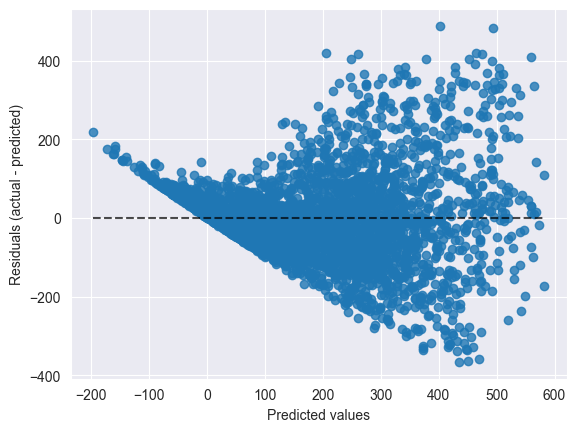

In [322]:
from sklearn.metrics import PredictionErrorDisplay

display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()

## Applying Standardization to columns with real data values

In [323]:
scaler = StandardScaler()

X_train['temp'] = scaler.fit_transform(np.asarray(X_train['temp']).reshape(-1, 1))
X_test['temp'] = scaler.fit_transform(np.asarray(X_test['temp']).reshape(-1, 1))

X_train['hum'] = scaler.fit_transform(np.asarray(X_train['hum']).reshape(-1, 1))
X_test['hum'] = scaler.fit_transform(np.asarray(X_test['hum']).reshape(-1, 1))

In [324]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

score = mean_squared_error(y_test, y_pred)
score

11844.67553739032

In [325]:
score = mean_absolute_error(y_test, y_pred)
score

78.2559335443038

In [326]:
score = r2_score(y_test, y_pred)
score

0.6259427862301785

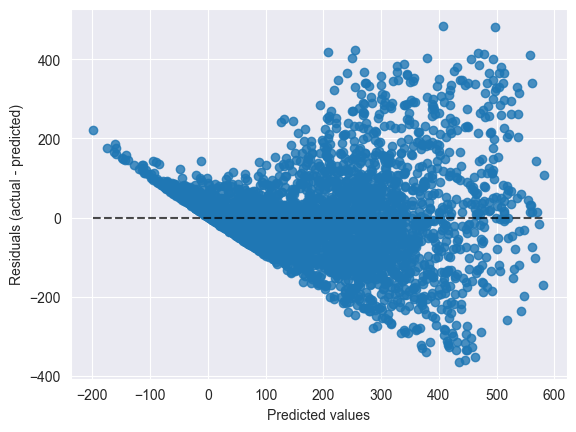

In [327]:
from sklearn.metrics import PredictionErrorDisplay

display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
display.plot()

plt.show()